In [ ]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import xml.etree.ElementTree as Xet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from IPython.display import Image, HTML

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.1.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [3]:
GOOD_REVIEW_THRESHOLD = 7

In [4]:
VAL_FRACTION = 0.25

## GET DATA

In [5]:
def get_hot_data():
    hot = requests.get("https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame").content.decode()
  
    # Parsing the XML file
    xmlparse = Xet.fromstring(hot)

    hot_array = []
    for item in xmlparse:
        dict_element = {
            "id": item.get("id"),
            "rank": item.get("rank")
        }
        for option in item:
            dict_element[option.tag] = option.get("value")
        hot_array.append(dict_element)
    return hot_array

In [6]:
def get_comments(id_array, verbose=1):
    max_comments_per_page = 1
    array_ids = [h['id'] for h in id_array]
    ids = ','.join(array_ids)
    page_size = 100
    page_number = 0
    comments_array = []

    while max_comments_per_page > 0 and len(array_ids) > 0:
        page_number += 1
        if verbose>0 and page_number%verbose==0:
            print(f"page number = {page_number}", end=" ")
        comments = requests.get(f"https://www.boardgamegeek.com/xmlapi2/thing?id={ids}&comments=1&pagesize={page_size}&page={page_number}").content.decode()

        # Parsing the XML file
        xmlparse = Xet.fromstring(comments)
        comments_per_item = []
        for item in xmlparse:        
            for option in item:
                if option.tag == 'comments':
                    comments_per_page = 0
                    for comment in option:
                        comments_per_page += 1
                        dict_element = {
                            "id": item.get("id"),
                            "username": comment.get("username"),
                            "rating": comment.get("rating"),
                            "value": comment.get("value")
                        }
                        comments_array.append(dict_element)
                    if comments_per_page==0:
                        array_ids.remove(item.get("id"))
                        ids = ','.join(array_ids)
                    comments_per_item.append(comments_per_page)
        max_comments_per_page = max(comments_per_item)
        if verbose>0 and page_number%verbose==0:
            print(f"(max: {max(comments_per_item)}, len: {len(comments_per_item)})")
    comments_df = pd.DataFrame(comments_array)
    print(f"comments_df shape: {comments_df.shape}")
    return comments_df

In [7]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '328866',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/N0hCcxXw8d7vUjKfsYO6vg__thumb/img/K4DDlRzl6qlQf9L_oMLb7g9WUYo=/fit-in/200x150/filters:strip_icc()/pic6121929.png',
  'name': "My Father's Work",
  'yearpublished': '2021'},
 {'id': '316624',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/eUiju5SqZbkNt8gnEofrTw__thumb/img/zNkmLNyeXJGOY24FeAAf4U67ejU=/fit-in/200x150/filters:strip_icc()/pic6035127.png',
  'name': 'Stationfall',
  'yearpublished': '2021'}]

In [21]:
try:
    comments_df = pd.read_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

reading dataframe from csv file...


,id,username,rating,value
0,328866,4tsawicki,N/A,Feb 2022
1,328866,alexbatbee,N/A,KS
2,328866,Amekins,N/A,Backer # 1267 on Kickstarter 4/27/2021 Funded ...
3,328866,basstoneslap,N/A,Kickstarter (February 2022)
4,328866,bigduff,N/A,Pre-ordered on Origames web store
...,...,...,...,...
116869,167791,z_zadar,9,Some games are so much fun. Others can be a li...
116870,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
116871,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
116872,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## SPLIT RATED AND NON-RATED COMMENTS

In [22]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

N/A                  26613
9.0                  17937
10.0                 17189
8.0                  16658
7.0                   9514
                     ...  
8.527999999999999        1
8.5711                   1
9.435                    1
9.166                    1
4.17                     1
Name: rating, Length: 599, dtype: int64

In [23]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(90261, 4)

In [24]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(26613, 4)

## CREATE TRAINING AND VALIDATION DATA

In [25]:
# use rated comments (reviews) to train the model

In [26]:
rated_comments = rated_comments.sample(frac=1)

In [27]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [28]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'Simple, fun, very good game.'

In [29]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'No clue why people rave about this. Decidedly average and brings nothing new to the arena.'

In [30]:
# create validation dataset from training
validation_len = int(len(train_examples)*VAL_FRACTION)
validation_len

x_val = train_examples[:validation_len]
x_train = train_examples[validation_len:]

y_val = train_labels[:validation_len]
y_train = train_labels[validation_len:]

## COMPOSE MODEL

In [31]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:2])

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.46755072, -0.02320543,  0.22071896, -0.15638234, -0.06248093,
        -0.16548505,  0.12768498,  0.07444887, -0.2733388 ,  0.0947848 ,
         0.08273078, -0.1262087 ,  0.19443244, -0.11807169,  0.3041907 ,
         0.37577832,  0.17393853,  0.24039814,  0.22214295,  0.02520681,
        -0.00295041, -0.27314347, -0.06507327, -0.2407716 , -0.06604367,
        -0.27780125,  0.00206299, -0.08527192,  0.03793108,  0.08759229,
        -0.11574811,  0.21155566, -0.01900212, -0.1326804 , -0.02752361,
         0.06245934,  0.01123472, -0.11676064, -0.05197624, -0.20400001,
         0.04676122, -0.09984155, -0.00339163, -0.08538881,  0.16018741,
        -0.18294655, -0.05511319, -0.07354705, -0.07645508,  0.02568765],
       [ 0.58989614,  0.44516218, -0.18534064,  0.32290488, -0.03633055,
         0.00314981,  0.16263133,  0.04787018, -0.6975449 ,  0.5575817 ,
         0.3109313 ,  0.31570143, -0.08539514,  0.3128588 , -0.15841687,
 

In [32]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]
)

## TRAINING MODEL 

In [34]:
history = model.fit(
    x_train,
    y_train,
    epochs=40,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=2
)

Train on 67696 samples, validate on 22565 samples
Epoch 1/40
67696/67696 - 41s - loss: 0.4690 - accuracy: 0.8310 - val_loss: 0.3681 - val_accuracy: 0.8529
Epoch 2/40
67696/67696 - 40s - loss: 0.3213 - accuracy: 0.8714 - val_loss: 0.3207 - val_accuracy: 0.8748
Epoch 3/40
67696/67696 - 41s - loss: 0.2709 - accuracy: 0.8924 - val_loss: 0.3133 - val_accuracy: 0.8780
Epoch 4/40
67696/67696 - 41s - loss: 0.2400 - accuracy: 0.9043 - val_loss: 0.3187 - val_accuracy: 0.8759
Epoch 5/40
67696/67696 - 41s - loss: 0.2169 - accuracy: 0.9149 - val_loss: 0.3295 - val_accuracy: 0.8717
Epoch 6/40
67696/67696 - 40s - loss: 0.1982 - accuracy: 0.9235 - val_loss: 0.3477 - val_accuracy: 0.8686
Epoch 7/40
67696/67696 - 40s - loss: 0.1832 - accuracy: 0.9301 - val_loss: 0.3681 - val_accuracy: 0.8654
Epoch 8/40
67696/67696 - 40s - loss: 0.1704 - accuracy: 0.9347 - val_loss: 0.3883 - val_accuracy: 0.8558
Epoch 9/40
67696/67696 - 40s - loss: 0.1581 - accuracy: 0.9398 - val_loss: 0.4076 - val_accuracy: 0.8572
Epoch

In [35]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [37]:
epochs = range(1, len(acc) + 1) 

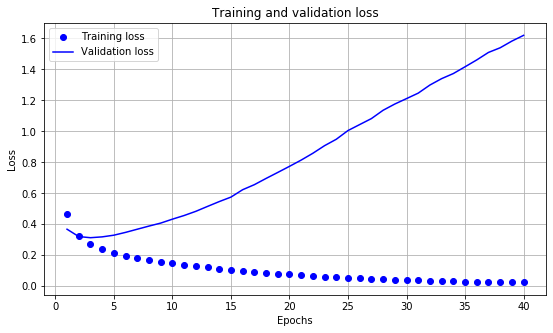

In [38]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

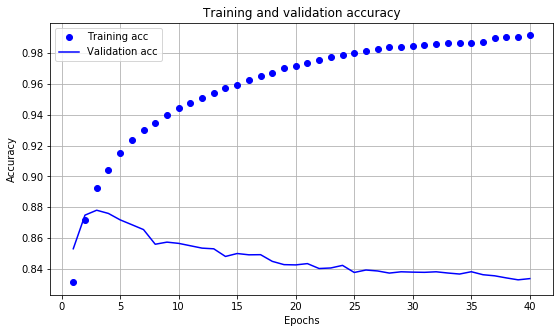

In [39]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [40]:
def print_my_examples(inputs, results, actual_values=None, limit=None):
    if actual_values is None:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}' for i in range(len(inputs))]
    else:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}\nactual value:{actual_values[i]}' for i in range(len(inputs))]
    if limit:
        result_for_printing = result_for_printing[:limit]
    print(*result_for_printing, sep='\n\n')

In [41]:
inputs = x_train[:10]
outputs = y_train[:10]
results = tf.sigmoid(model.predict(tf.constant(inputs)))
print_my_examples(inputs, results, outputs)

input:
"This is a racing game, perhaps in the abstract but none the less a racing game.  It is possible that one might beat the player who triggered the ending, but this is highly unlikely with experienced players.  The first half of the game is fun, but the second half seems to be over too quickly.  One player scored twenty points in one turn and bam the game was over.  The cards seem very swingy, with some very powerful no matter what and others being powerful only under certain conditions or with a few actions necessary to maximize results.  The variance in the cards I guess is fine because they are random draws but the cards can really break the game, which again is ok if they are all in the same league of breaking ability.  However, there were many cards that just seemed worthless or so specific in conditions as to rarely occur.    Ultimately, I don't hate the game but I think it really needs work for me to want to play it more than once in awhile.  For example, more locations wou

In [42]:
## APPLY MODEL ON NON-RATED COMMENTS

In [46]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(not_rated_comments.value.astype(str)))))
print_my_examples(list(not_rated_comments.value), results, limit=25)

input:
"1–5 Players Best 4 90–115 Min "
score: 1.000000

input:
"Intense game.  It's all about the hidden scoring, which is revealed at the end.  Kinds reminded me of the bonus cards at the end of Stone Age.  Seems it's best to specialize in one area.  In the game I played the winner (who wasn't me), got 7 scoring cards for areas and was able to build in all 12 areas for a 84 points in that one category.  Good healthy tension throughout the game as there is always more you want to do."
score: 1.000000

input:
"NIS  3.9"
score: 0.103566

input:
"agost 2021  https://www.kickstarter.com/projects/matagot/kemet-blood-and-sand?ref=user_menu"
score: 0.253931

input:
"Top of D"
score: 0.999224

input:
"Individual Up for Sale "
score: 1.000000

input:
"2020 - Purchased from 401 Games"
score: 0.987447

input:
"inkl. Metallmünzen"
score: 0.613820

input:
"Cull candidate:  Need to play to see if 2p is as loose as and solitaire/nonconfrontational it looks. (Which I don't like)  Still looks like fun

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [47]:
rated_comments.head()

,id,username,rating,value
34199,284083,jacky123kai,10,"Simple, fun, very good game."
85637,124361,skutsch,9,Elegant gameplay but with some depth (that I h...
116802,167791,zerstorer88,10,Very fine! Excellenti Calienti!
32751,174430,brewgeek,9,KS this.
94903,266192,RippedFromTheCrypt,6.5,No clue why people rave about this. Decidedly ...


In [48]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
rated_comments_grouped.head()

,id,rating_mean,rating_count
0,115746,8.727459,1893
1,124361,8.183466,3828
2,148228,7.381163,7294
3,162886,8.349107,3474
4,167355,8.418500,1772


In [49]:
not_rated_comments['rating'] = [round(float(r[0])*10, 1) for r in results]

In [50]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
not_rated_comments_grouped.head()

,id,rating_mean,rating_count
0,115746,8.832006,703
1,124361,8.877467,821
2,148228,8.487179,1482
3,162886,8.792270,1022
4,167355,8.850812,677


In [55]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'))
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")

In [56]:
grouped.head()

,id,rating_mean_review,rating_count_review,rating_mean_comments,rating_count_comments,rank,thumbnail,name,yearpublished,url
0,115746,8.727459,1893,8.832006,703,47,https://cf.geekdo-images.com/ImPgGag98W6gpV1KV...,War of the Ring: Second Edition,2012,https://boardgamegeek.com/boardgame/115746
1,124361,8.183466,3828,8.877467,821,45,https://cf.geekdo-images.com/CzwSm8i7tkLz6cBnr...,Concordia,2013,https://boardgamegeek.com/boardgame/124361
2,148228,7.381163,7294,8.487179,1482,46,https://cf.geekdo-images.com/rwOMxx4q5yuElIvo-...,Splendor,2014,https://boardgamegeek.com/boardgame/148228
3,162886,8.349107,3474,8.792270,1022,11,https://cf.geekdo-images.com/a13ieMPP2s0KEaKNY...,Spirit Island,2017,https://boardgamegeek.com/boardgame/162886
4,167355,8.418500,1772,8.850812,677,28,https://cf.geekdo-images.com/tAqLpWxQ0Oo3GaPP3...,Nemesis,2018,https://boardgamegeek.com/boardgame/167355


In [57]:
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) / (grouped['rating_count_review']+grouped['rating_count_comments'])

In [58]:
grouped.head()

,id,rating_mean_review,rating_count_review,rating_mean_comments,rating_count_comments,rank,thumbnail,name,yearpublished,url,fixed_rating
0,115746,8.727459,1893,8.832006,703,47,https://cf.geekdo-images.com/ImPgGag98W6gpV1KV...,War of the Ring: Second Edition,2012,https://boardgamegeek.com/boardgame/115746,8.755770
1,124361,8.183466,3828,8.877467,821,45,https://cf.geekdo-images.com/CzwSm8i7tkLz6cBnr...,Concordia,2013,https://boardgamegeek.com/boardgame/124361,8.306025
2,148228,7.381163,7294,8.487179,1482,46,https://cf.geekdo-images.com/rwOMxx4q5yuElIvo-...,Splendor,2014,https://boardgamegeek.com/boardgame/148228,7.567936
3,162886,8.349107,3474,8.792270,1022,11,https://cf.geekdo-images.com/a13ieMPP2s0KEaKNY...,Spirit Island,2017,https://boardgamegeek.com/boardgame/162886,8.449844
4,167355,8.418500,1772,8.850812,677,28,https://cf.geekdo-images.com/tAqLpWxQ0Oo3GaPP3...,Nemesis,2018,https://boardgamegeek.com/boardgame/167355,8.538008


In [59]:
grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished', 'url']]

In [60]:
def path_to_image_html(path):
    return f'<img src="{path}" width="124" />'

def path_to_url_html(url):
    return f'<a href="{url}">link</a>'

In [61]:
# TOP 5 RANK
HTML(grouped.sort_values('rank').head(5).to_html(escape=False, formatters={'thumbnail': path_to_image_html, 'url': path_to_url_html}))

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished,url
46,,My Father's Work,6.125000,9.250000,8.654762,1,2021,link
44,,Stationfall,9.500000,9.050000,9.275000,2,2021,link
41,,Lost Ruins of Arnak,7.932996,8.650579,8.145158,3,2020,link
43,,Dune: Imperium,8.120048,8.867568,8.316438,4,2020,link
42,,Vivid Memories,7.666667,7.840000,7.775000,5,2021,link


In [62]:
# TOP 5 REVIEW RANK
HTML(grouped.sort_values('rating_mean_review', ascending=False).head(5).to_html(escape=False, formatters={'thumbnail': path_to_image_html, 'url': path_to_url_html}))

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished,url
44,,Stationfall,9.500000,9.050000,9.275000,2,2021,link
48,,Marvel United: X-Men,9.000000,9.335135,9.326316,27,2022,link
22,,Eclipse: Second Dawn for the Galaxy,8.732016,8.819313,8.762928,37,2020,link
0,,War of the Ring: Second Edition,8.727459,8.832006,8.755770,47,2012,link
17,,Brass: Birmingham,8.690429,8.718535,8.698474,18,2018,link


In [63]:
# TOP 5 FIXED RANK
HTML(grouped.sort_values('fixed_rating', ascending=False).head(5).to_html(escape=False, formatters={'thumbnail': path_to_image_html, 'url': path_to_url_html}))

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished,url
48,,Marvel United: X-Men,9.000000,9.335135,9.326316,27,2022,link
44,,Stationfall,9.500000,9.050000,9.275000,2,2021,link
38,,Kemet: Blood and Sand,8.687500,9.065922,9.021182,34,2021,link
31,,Merchants Cove,8.376667,9.010596,8.905525,8,2021,link
22,,Eclipse: Second Dawn for the Galaxy,8.732016,8.819313,8.762928,37,2020,link


In [64]:
# model.save('saved_model\my_model')

In [65]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [66]:
# some examples on "long" comments vs short comments

In [67]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()

In [68]:
# some long comments
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(some_long_comments.value))))
print_my_examples(list(some_long_comments.value), results, limit=25)

input:
"Tried playing once, was way too complicated and fiddly for us. Also realized I'm not a huge fan of co-ops. The card powers were cool though."
score: 0.000000

input:
"Estimated Release Date is Feb 28th, 2021  https://www.cardhaus.com/account.php?action=view_order&order_id=94352"
score: 1.000000

input:
"El pelotazo de 2017. A ver si veo en Youtube cómo es y me hago una idea. Creo que para mis habituales no encaja, así que tiene pinta de que nada..."
score: 0.065955

input:
"Watched Rahdo's runthrough, looks like fun. In a way a more accessible and simpler version of Terraforming Mars with drafting and engine building over only 4 rounds. Also like the art / table presence. Definitely want to play, cool stuff!"
score: 0.924304

input:
"Backer # 1267 on Kickstarter 4/27/2021 Funded May 14 2021 Pledge level: New Generation $99 Anticipated delivery date Feburary 2022"
score: 1.000000

input:
"Kickstarted: Core Box Pledge Medic Character Pack Alien Kings set  Space Cats collection Ca